In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import metrics

import matplotlib.pyplot as plt
import random as random
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
import sklearn.linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score

from sklearn import linear_model #TODO: more models
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import sparse

from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import roc_curve
from sklearn.preprocessing import scale


import statsmodels.api as sm

from sklearn import feature_selection


from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

//anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading the input dataset

In [2]:
curr_dir = !pwd
input_path = curr_dir[0]+"/../9.Features_exploration/binding_df/10/"
filename = "positions_features.csv"

features_all = pd.read_csv(input_path+filename, sep='\t', index_col=0)
features_cols = features_all.columns[1:-6] #removing binding scores and domain name
ligands = ["dna", "rna", "peptide", "ion", "metabolite"]

In [4]:
non_binding_positions.shape

(37433, 298)

In [3]:
features_all.shape

(53933, 305)

In [7]:
features_all.index

Index([u'2OG-FeII_Oxy_3_1', u'2OG-FeII_Oxy_3_10', u'2OG-FeII_Oxy_3_11',
       u'2OG-FeII_Oxy_3_12', u'2OG-FeII_Oxy_3_13', u'2OG-FeII_Oxy_3_14',
       u'2OG-FeII_Oxy_3_15', u'2OG-FeII_Oxy_3_16', u'2OG-FeII_Oxy_3_17',
       u'2OG-FeII_Oxy_3_18',
       ...
       u'zf-rbx1_50', u'zf-rbx1_51', u'zf-rbx1_52', u'zf-rbx1_53',
       u'zf-rbx1_54', u'zf-rbx1_55', u'zf-rbx1_6', u'zf-rbx1_7', u'zf-rbx1_8',
       u'zf-rbx1_9'],
      dtype='object', length=53933)

In [28]:
53933 - 43972

9961

### Checking input features doesn't have NaNs

In [3]:
for col in features_cols:
    nan_idx = np.where( np.isnan(features_all[col].tolist()) == True)[0]
    if (len(nan_idx) > 0):
        print col+" has NaNs"

### Checking input features doesn't have Infs

In [4]:
for col in features_cols:
    inf_idx = np.where(np.isinf(features_all[col].tolist()) == True)[0]
    if (len(inf_idx) > 0):
        print col+" has Inf"

### Dataset of negative examples

In [3]:
non_binding_positions = features_all[features_all["max_binding_score"] == 0]
non_binding_positions = non_binding_positions.loc[:,features_cols]

### Datasets of positive examples by ligand

In [4]:
bind_th = 0.1
ligands_features_df = {}

for ligand in ligands:
    score_col_str = ligand+"_binding_score"
    ligand_binding_df = features_all[features_all[score_col_str] >= bind_th]
    ligands_features_df[ligand] = ligand_binding_df.loc[:,features_cols]

### Test features

In [9]:
print(features_list.shape)

(298,)


In [5]:
# Down-sample
def get_sample(ligand_bind_features,non_binding_positions):
    negative_idx = range(0,len(non_binding_positions))
    sampled_negative_idx = sample(iter(negative_idx), len(ligand_bind_features))
    X = pd.concat([ligand_bind_features, non_binding_positions.iloc[sampled_negative_idx]])

    y = [1] * ligand_bind_features.shape[0]
    y.extend([0] * ligand_bind_features.shape[0])
    y = np.array(y)
    return [X,y]

In [113]:
## Linear Regression
for ligand in ligands:
    #Initialize dictionary
    weights = defaultdict(list)
    
    # Set params
    ligand_bind_features = ligands_features_df[ligand]
    
    X,y = get_sample(ligand_bind_features,non_binding_positions)
    
    #X = pd.concat([ligand_bind_features, non_binding_positions])
    #y = [1]*ligand_bind_features.shape[0] + [0]*non_binding_positions.shape[0]
    
    # Fit model and get coefficients
    model = LinearRegression().fit(X,y)
    coeffs = model.coef_
    
    # Update dataframe
    features_df.loc["Linreg_"+ligand,:] = coeffs
    print "Finished ligand "+ligand

Finished ligand dna
Finished ligand rna
Finished ligand peptide
Finished ligand ion
Finished ligand metabolite


In [17]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier


# List of features
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Dataframe to hold feature selection results - 1 indicates retention at the threshold
features_df = pd.DataFrame(columns=features_list)

for ligand in ligands:
    # Down-sample
    X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
    # Feature selection models
    var_model = VarianceThreshold(threshold=(.3)).fit(X)
    kbest_model = SelectKBest(k=200).fit(X,y)
    trees_model = ExtraTreesClassifier().fit(X,y)
    # Store results
    features_df.loc["Vartest_0.1_"+ligand] = np.asarray(var_model.get_support()).astype(int)
    features_df.loc["kbest_200_"+ligand] = np.asarray(kbest_model.get_support()).astype(int)
    features_df.loc["Trees_"+ligand,:] = np.asarray(trees_model.feature_importances_ > 1.0/len(features_list)).astype(int)

In [21]:
features_df
#sum(np.asarray(trees_model.feature_importances_ > 1.0/len(features_list)).astype(int))

,avg_maf_all,avg_maf_altered,maf_hist_0-0.001,maf_hist_0.001-0.005,maf_hist_0.005-0.01,maf_hist_0.01-0.02,maf_hist_0.02-0.04,maf_hist_0.04-0.06,maf_hist_0.06-0.08,maf_hist_0.08-0.1,...,aa_alt_avg_freq_prob_N,aa_alt_avg_freq_prob_P,aa_alt_avg_freq_prob_Q,aa_alt_avg_freq_prob_R,aa_alt_avg_freq_prob_S,aa_alt_avg_freq_prob_T,aa_alt_avg_freq_prob_V,aa_alt_avg_freq_prob_W,aa_alt_avg_freq_prob_Y,aa_alt_avg_freq_prob_*
Vartest_0.1_dna,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kbest_200_dna,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Trees_dna,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Vartest_0.1_rna,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kbest_200_rna,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Trees_rna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Vartest_0.1_peptide,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kbest_200_peptide,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Trees_peptide,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Vartest_0.1_ion,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#%%time
# Models with features removed for variance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

#thresh_list = [0.01, 0.05, 0.1, 0.3, 0.5]
#thresh_list = [298, 275, 250, 200, 150, 100]
thresh_list = [0, 0.0001, 0.0005, 0.001, 0.003, 0.004]

for thresh in thresh_list:
    for ligand in ligands:
        #Initialize dictionary
        pred_dict = defaultdict(list)
        auc_dict = defaultdict(list)

        # Remove features
        X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
        #model = VarianceThreshold(threshold=thresh).fix(X)
        #model = SelectKBest(k=thresh).fit(X,y)
        model = ExtraTreesClassifier().fit(X,y)
        #features_included = model.get_support()
        features_included = model.feature_importances_ > thresh

        # Run classifier
        test_model(pred_dict, auc_dict, ligands_features_df[ligand], ligand, features_included)

        pred_df = pd.DataFrame.from_dict(pred_dict)
        auc_df = pd.DataFrame.from_dict(auc_dict)

        #Save to file
        pred_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_0.1_trees_"+str(thresh)+".csv", sep='\t')
        auc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_0.1_auc_trees_"+str(thresh)+".csv", sep='\t')

        print "Finished ligand "+ligand
    print("Finished threshold: "+str(thresh))

avg auc = 0.755498732495
Finished dna KNN
avg auc = 0.771279031672
Finished dna SVM
avg auc = 0.672961896089
Finished dna Ridge
avg auc = 0.771029777945
Finished dna RF
avg auc = 0.732873054291
Finished dna Logistic
avg auc = 0.68018520994
Finished dna Lasso
Finished ligand dna
avg auc = 0.709177904435
Finished rna KNN
avg auc = 0.743670831341
Finished rna SVM
avg auc = 0.670825623788
Finished rna Ridge
avg auc = 0.787763293878
Finished rna RF
avg auc = 0.645935719448
Finished rna Logistic
avg auc = 0.65144428285
Finished rna Lasso
Finished ligand rna
avg auc = 0.645909468074
Finished peptide KNN
avg auc = 0.65360250561
Finished peptide SVM
avg auc = 0.639598640555
Finished peptide Ridge
avg auc = 0.64964290826
Finished peptide RF
avg auc = 0.642317410019
Finished peptide Logistic
avg auc = 0.645379015212
Finished peptide Lasso
Finished ligand peptide
avg auc = 0.704377725708
Finished ion KNN
avg auc = 0.711830565271
Finished ion SVM
avg auc = 0.692645533253
Finished ion Ridge
avg auc 

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


avg auc = 0.688347244765
Finished dna Lasso
Finished ligand dna
avg auc = 0.720456141653
Finished rna KNN
avg auc = 0.770528991061
Finished rna SVM
avg auc = 0.696062524849
Finished rna Ridge
avg auc = 0.779863563913
Finished rna RF
avg auc = 0.621242570828
Finished rna Logistic
avg auc = 0.63635786527
Finished rna Lasso
Finished ligand rna
avg auc = 0.647054206641
Finished peptide KNN
avg auc = 0.658081187704
Finished peptide SVM
avg auc = 0.635929584661
Finished peptide Ridge
avg auc = 0.651573577841
Finished peptide RF
avg auc = 0.650003952388
Finished peptide Logistic
avg auc = 0.651801430795
Finished peptide Lasso
Finished ligand peptide
avg auc = 0.70338641496
Finished ion KNN
avg auc = 0.715901154925
Finished ion SVM
avg auc = 0.702155179689
Finished ion Ridge
avg auc = 0.708214681515
Finished ion RF
avg auc = 0.675060691528
Finished ion Logistic
avg auc = 0.609119846006
Finished ion Lasso
Finished ligand ion
avg auc = 0.590067494643
Finished metabolite KNN
avg auc = 0.628156691

In [115]:
## Select K best
from sklearn.feature_selection import SelectKBest

for ligand in ligands:
    ligand_bind_features = ligands_features_df[ligand]
    X,y = get_sample(ligand_bind_features,non_binding_positions)
    #X = pd.concat([ligand_bind_features, non_binding_positions])
    #y = [1]*ligand_bind_features.shape[0] + [0]*non_binding_positions.shape[0]
    
    model = SelectKBest(k=100).fit(X, y)
    features_df.loc["100Best_"+ligand] = [int(i) for i in model.get_support()]

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [174 195] are constant.
  UserWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [116]:
## Tree-based -- Importances add to one
from sklearn.ensemble import ExtraTreesClassifier

for ligand in ligands:
    ligand_bind_features = ligands_features_df[ligand]
    X,y = get_sample(ligand_bind_features,non_binding_positions)
    #X = pd.concat([ligand_bind_features, non_binding_positions])
    #y = [1]*ligand_bind_features.shape[0] + [0]*non_binding_positions.shape[0]
    model = ExtraTreesClassifier().fit(X,y)
    features_df.loc["Trees_"+ligand,:] = model.feature_importances_

### classifier for a particular ligand-binding
#### Test different algorithms

In [6]:
def sample(iterator, k):
    """
    Samples k elements from an iterable object.

    :param iterator: an object that is iterable
    :param k: the number of items to sample
    """
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]

    n = k - 1
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item

    return result

In [7]:
def test_model(pred_dict, auc_dict, ligand_bind_features, ligand_name, features=[]):
    class_idx = 1
    
    # Default: Exclude no features
    if len(features) == 0:
        print("hi")
        features = np.ones([ligand_bind_features.shape[1],])
    
    classifiers = {}
    classifiers["Logistic"] = LogisticRegression()
    classifiers["RF"] = ensemble.RandomForestRegressor(n_estimators=1000)  
    classifiers["KNN"] = neighbors.KNeighborsRegressor(n_neighbors=100)
    classifiers["Lasso"] = linear_model.Lasso()
    classifiers["Ridge"] = linear_model.RidgeClassifier()
    classifiers["SVM"] = svm.SVC(kernel='rbf', probability=True)
    
    predict_th = 0.5
    models_req_scaling = ["SVM", "KNN"]
    
    for classifier in classifiers.keys():
        #print "starting "+ligand_name+": "+classifier
        model = classifiers[classifier]
        auc_sum = 0
        #Create X and y
        X = pd.concat([ligand_bind_features.iloc[:,features], non_binding_positions.iloc[:,features]])

        if (classifier in models_req_scaling):
            X = pd.DataFrame(scale(X)) #Is z-scoring the data needed?

        y = [1] * ligand_bind_features.shape[0]
        y.extend([0] * non_binding_positions.shape[0])
        y = np.array(y)

        binding_skf = StratifiedKFold(n_splits=10)
        pred_idx = 1

        for train_index, test_index in binding_skf.split(X, y):
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]

            #Down-sample negative examples to have balanced classes
            negative_idx = np.where(y_train == 0)[0].tolist()
            positive_idx = np.where(y_train == 1)[0].tolist()
            sampled_negative_idx = sample(iter(negative_idx), len(positive_idx))
            X_train_sampled = pd.concat([X_train.iloc[positive_idx], X_train.iloc[sampled_negative_idx]])
            y_train_sampled = np.append(y_train[positive_idx], [0] * len(positive_idx))
            
            #fit to training data
            model = classifiers[classifier]
            model.fit(X_train_sampled, y_train_sampled)
            probs_list = []

            if (classifier == "Logistic" or classifier == "SVM"):
                probs = model.predict_proba(X_test)
                predicted = log_predict_threshold(probs, predict_th, class_idx)
                for l in probs:
                    probs_list.append(l[1])
            elif (classifier == "Ridge"):
                probs = model.decision_function(X_test)
                predicted = model.predict(X_test)
                probs_list = probs
            else:
                probs = model.predict(X_test)
                predicted = predict_threshold(probs, predict_th)
                probs_list = probs

            #predicted = model.predict(X_test)

            pred_dict["pred"].extend(predicted)
            pred_dict["obs"].extend(y_test)

            pred_dict["prob"].extend(probs_list)

            fold_list = [pred_idx] * len(predicted)
            pred_dict["fold"].extend(fold_list)

            model_list = [classifier] * len(predicted)
            pred_dict["model"].extend(model_list)

            if (classifier == "Logistic" or classifier == "SVM"):
                #print "auc= "+str(metrics.roc_auc_score(y_test, probs[:, 1]))
                auc_dict[classifier].append(metrics.roc_auc_score(y_test, probs[:, 1]))
            else:
                #print "auc= "+str(metrics.roc_auc_score(y_test, probs))
                auc_dict[classifier].append(metrics.roc_auc_score(y_test, probs))

            pred_idx += 1

        avg_auc = np.sum(auc_dict[classifier])/10.0
        print "avg auc = "+str(avg_auc)
            
        print "Finished "+ligand+" "+classifier

In [367]:
%%time

for ligand in ligands:
    #Initialize dictionary
    pred_dict = defaultdict(list)
    
    auc_dict = defaultdict(list)
    
    test_model(pred_dict, auc_dict, ligands_features_df[ligand], ligand)
    
    pred_df = pd.DataFrame.from_dict(pred_dict)
    auc_df = pd.DataFrame.from_dict(auc_dict)
    
    #Save to file
    pred_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1.csv", sep='\t')
    auc_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1_auc.csv", sep='\t')
    
    print "Finished ligand "+ligand
    
    if (ligand == "rna"):
        break

avg auc = 0.745087757415
Finished dna KNN
avg auc = 0.754990357
Finished dna SVM
avg auc = 0.682816408904
Finished dna Ridge
avg auc = 0.759866291433
Finished dna RF
avg auc = 0.734007237384
Finished dna Logistic
avg auc = 0.668867048211
Finished dna Lasso
Finished ligand dna
avg auc = 0.710019595585
Finished rna KNN
avg auc = 0.749518304767
Finished rna SVM
avg auc = 0.676620901165
Finished rna Ridge
avg auc = 0.77285611902
Finished rna RF
avg auc = 0.631550523787
Finished rna Logistic
avg auc = 0.639909792116
Finished rna Lasso
Finished ligand rna
CPU times: user 9min 5s, sys: 8.22 s, total: 9min 13s
Wall time: 7min 49s


In [356]:
%%time

for ligand in ligands:
    #Initialize dictionary
    pred_dict = defaultdict(list)
    
    auc_dict = defaultdict(list)
    
    test_model(pred_dict, auc_dict, ligands_features_df[ligand], ligand)
    
    pred_df = pd.DataFrame.from_dict(pred_dict)
    auc_df = pd.DataFrame.from_dict(auc_dict)
    
    #Save to file
    pred_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1.csv", sep='\t')
    auc_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1_auc.csv", sep='\t')
    
    print "Finished ligand "+ligand

avg auc = 0.740264236484
Finished dna KNN
avg auc = 0.768621724074
Finished dna SVM
avg auc = 0.67596361898
Finished dna Ridge
avg auc = 0.767344420326
Finished dna RF
avg auc = 0.780124040608
Finished dna Logistic
avg auc = 0.664295744286
Finished dna Lasso
Finished ligand dna
avg auc = 0.710853303498
Finished rna KNN
avg auc = 0.731779672535
Finished rna SVM
avg auc = 0.654061587859
Finished rna Ridge
avg auc = 0.749047266828
Finished rna RF
avg auc = 0.652025837547
Finished rna Logistic
avg auc = 0.639261341477
Finished rna Lasso
Finished ligand rna
avg auc = 0.643810069289
Finished peptide KNN
avg auc = 0.658307595548
Finished peptide SVM
avg auc = 0.628726821818
Finished peptide Ridge
avg auc = 0.640462437759
Finished peptide RF
avg auc = 0.640741385723
Finished peptide Logistic
avg auc = 0.65392740998
Finished peptide Lasso
Finished ligand peptide
avg auc = 0.70295255617
Finished ion KNN
avg auc = 0.715842316142
Finished ion SVM
avg auc = 0.695427109967
Finished ion Ridge
avg auc

### Classifier for ligands- combined

In [ ]:
%%time
all_ligands_features_df = pd.concat([ligands_features_df["dna"], ligands_features_df["rna"], ligands_features_df["ion"], ligands_features_df["peptide"], ligands_features_df["metabolite"]])
print "shape = "+str(ligands_features_df_not_con.shape[0])
pred_dict = defaultdict(list)
auc_dict = defaultdict(list)

ligand = "all_ligands"
print "Starting all_ligands"
test_model(pred_dict, auc_dict, all_ligands_features_df, ligand)

pred_df = pd.DataFrame.from_dict(pred_dict)
auc_df = pd.DataFrame.from_dict(auc_dict)

#Save to file
pred_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1.csv", sep='\t')
auc_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_0.1_auc.csv", sep='\t')

### Predict without the most conserved positions

In [363]:
%%time


for ligand in ligands:
    
    pred_dict = defaultdict(list)
    auc_dict = defaultdict(list)
    
    ligands_features_df_not_con = ligands_features_df[ligand][ligands_features_df[ligand]["pfam_prob_max"] <= 0.5]
    print "shape = "+str(ligands_features_df_not_con.shape[0])
    
    test_model(pred_dict, auc_dict, ligands_features_df_not_con, ligand+"_not_con")
    
    pred_df = pd.DataFrame.from_dict(pred_dict)
    auc_df = pd.DataFrame.from_dict(auc_dict)
    
    #Save to file
    pred_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_not_con_0.1.csv", sep='\t')
    auc_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_not_con_0.1_auc.csv", sep='\t')
    
    print "Finished ligand "+ligand

shape = 241
avg auc = 0.73822613419
Finished dna KNN
avg auc = 0.750055211044
Finished dna SVM
avg auc = 0.669640151716
Finished dna Ridge
avg auc = 0.740379080195
Finished dna RF
avg auc = 0.708719516673
Finished dna Logistic
avg auc = 0.677096060783
Finished dna Lasso
Finished ligand dna
shape = 300
avg auc = 0.699148165369
Finished rna KNN
avg auc = 0.749874281351
Finished rna SVM
avg auc = 0.682377228566
Finished rna Ridge
avg auc = 0.794811906965
Finished rna RF
avg auc = 0.6344064288
Finished rna Logistic
avg auc = 0.661337001434
Finished rna Lasso
Finished ligand rna
shape = 1975
avg auc = 0.645546017437
Finished peptide KNN
avg auc = 0.665321987718
Finished peptide SVM
avg auc = 0.656102280747
Finished peptide Ridge
avg auc = 0.66765028829
Finished peptide RF
avg auc = 0.664319387086
Finished peptide Logistic
avg auc = 0.6515189361
Finished peptide Lasso
Finished ligand peptide
shape = 1207
avg auc = 0.626417022507
Finished ion KNN
avg auc = 0.642045385133
Finished ion SVM
avg 

### Predict all ligandstogether without the most conserved positions

In [25]:
%%time
class_idx = 1 #binding==1
all_ligands_features_df = pd.concat([ligands_features_df["dna"], ligands_features_df["rna"], ligands_features_df["ion"], ligands_features_df["peptide"], ligands_features_df["metabolite"]])
all_ligands_features_df_not_con = all_ligands_features_df[all_ligands_features_df["pfam_prob_max"] <= 0.5]

pred_dict = defaultdict(list)
auc_dict = defaultdict(list)

ligand = "all_ligands"
print "shape = "+str(all_ligands_features_df_not_con.shape[0])

test_model(pred_dict, auc_dict, all_ligands_features_df_not_con, ligand)

pred_df = pd.DataFrame.from_dict(pred_dict)
auc_df = pd.DataFrame.from_dict(auc_dict)

#Save to file
pred_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_not_con_0.1.csv", sep='\t')
auc_df.to_csv(curr_dir[0]+"/ligand_df/"+ligand+"_not_con_0.1_auc.csv", sep='\t')

shape = 5527
avg auc = 0.609236356596
Finished all_ligands KNN
avg auc = 0.646192150116
Finished all_ligands SVM
avg auc = 0.64294266209
Finished all_ligands Ridge
avg auc = 0.67890260806
Finished all_ligands RF
avg auc = 0.615440106691
Finished all_ligands Logistic
avg auc = 0.588222748658
Finished all_ligands Lasso


NameError: name 'pred_df' is not defined

# From this point: "testing code" - can be ignored

In [305]:
classifiers = {}
ligand_bind_features = ligands_features_df["dna"]
ligand = "DNA"
class_idx = 1 #binding==1
#classifiers["Ridge"] = linear_model.RidgeClassifier()
#classifiers["Logistic"] = LogisticRegression()
#classifiers["RandomForest"] = ensemble.RandomForestRegressor(n_estimators=1000)  
classifiers["KNN"] = neighbors.KNeighborsRegressor(n_neighbors=100)
#classifiers["Lasso"] = linear_model.Lasso()
predict_th = 0.5
#classifiers["SVM"] = svm.SVC(kernel='rbf', probability=True)

models_req_scaling = ["SVM", "KNN"]

auc_sum = 0
pred_dict = defaultdict(list)

for classifier in classifiers.keys():
    model = classifiers[classifier]

    #Create X and y
    X = pd.concat([ligand_bind_features, non_binding_positions])
    
    if (classifier in models_req_scaling):
        X = pd.DataFrame(scale(X)) #Is z-scoring the data needed?
        
    y = [1] * ligand_bind_features.shape[0]
    y.extend([0] * non_binding_positions.shape[0])
    y = np.array(y)

    binding_skf = StratifiedKFold(n_splits=10)
    pred_idx = 1

    for train_index, test_index in binding_skf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        #Down-sample negative examples to have balanced classes
        negative_idx = np.where(y_train == 0)[0].tolist()
        positive_idx = np.where(y_train == 1)[0].tolist()
        sampled_negative_idx = sample(iter(negative_idx), len(positive_idx))
        X_train_sampled = pd.concat([X_train.iloc[positive_idx], X_train.iloc[sampled_negative_idx]])
        y_train_sampled = np.append(y_train[positive_idx], [0] * len(positive_idx))

        model = classifiers[classifier]
        model.fit(X_train_sampled, y_train_sampled)
        probs_list = []

        if (classifier == "Logistic" or classifier == "SVM"):
            probs = model.predict_proba(X_test)
            predicted = log_predict_threshold(probs, predict_th, class_idx)
            for l in probs:
                probs_list.append(l[1])
        elif (classifier == "Ridge"):
            probs = model.decision_function(X_test)
            predicted = model.predict(X_test)
            probs_list = probs
        else:
            probs = model.predict(X_test)
            predicted = predict_threshold(probs, predict_th)
            probs_list = probs

        #predicted = model.predict(X_test)

        pred_dict["pred"].extend(predicted)
        pred_dict["obs"].extend(y_test)

        pred_dict["prob"].extend(probs_list)

        fold_list = [pred_idx] * len(predicted)
        pred_dict["fold"].extend(fold_list)

        model_list = [classifier+"_"+ligand] * len(predicted)
        pred_dict["model"].extend(model_list)

        #print (pred_idx)
        pred_idx += 1
        
        #print "accuracy = "+str(metrics.accuracy_score(y_test, predicted))
        if (classifier == "Logistic" or classifier == "SVM"):
            print "auc= "+str(metrics.roc_auc_score(y_test, probs[:, 1]))
            auc_sum += metrics.roc_auc_score(y_test, probs[:, 1])
        else:
            print "auc= "+str(metrics.roc_auc_score(y_test, probs))
            auc_sum += metrics.roc_auc_score(y_test, probs)
        #print metrics.classification_report(y_test, predicted) 

pred_df = pd.DataFrame.from_dict(pred_dict)
print "auc_avg = "+str(auc_sum/10.0)

auc= 0.63821638431
auc= 0.828210851648
auc= 0.821619352869
auc= 0.738435555895
auc= 0.812001450326
auc= 0.768181557956
auc= 0.603431166749
auc= 0.373750047708
auc= 0.915027098202
auc= 0.870978913725
auc_avg = 0.736985237939


In [317]:
pred_df[pred_df["fold"] == 1].shape

(3772, 5)

In [276]:
max(model.predict(X_test))

3.8929667990598773

### Divide the dataset into classes

In [3]:
def classes_by_threshold_3(features_table, bind_th, struct_th):
    """Given a features table, binding score threshold and Pfam emission prob. threshold,
    return tables of 3 classes:
    1) structural- positions with Pfam emission prob. >= th
    2) binding - positions with binding score >= th
    3) neutral - all other positions"""
    
    structural = features_table[features_table["pfam_prob_max"] >= struct_th]
    non_struct = features_table[features_table["pfam_prob_max"] < struct_th]
    binding = non_struct[non_struct["binding_score"] >= bind_th]
    neutral = non_struct[non_struct["binding_score"] < bind_th]
    del structural["binding_score"]
    del binding["binding_score"]
    del neutral["binding_score"]
    
    return (structural, binding, neutral)

In [4]:
def classes_by_threshold_2(features_table, bind_th):
    """Given a features table, binding score threshold and Pfam emission prob. threshold,
    return tables of 2 classes:
    1) binding - positions with binding score >= th
    2) non_binding - all other positions"""
    
    binding = features_table[features_table["binding_score"] >= bind_th]
    non_binding = features_table[features_table["binding_score"] < bind_th]
    del binding["binding_score"]
    del neutral["binding_score"]
    
    return (binding, non_binding)

### Add labeles vectors

In [5]:
def add_labels(features_table, label):
    "Add label column with label as data"
    labeld_table = features_table
    labeled_table["label"] = label

### Parameters to change in the model:
##### 1) binding threshold:
From that binding score threshold the truth value is defined as "binding".
##### 2) structural threshold
From what Pfam emission prob. the position is conserved and defined as "structural"
##### 3) Include/Ignore structural
Include "Structural" as a third class or no.
##### 4) Probability for predicting binding
From what prob of the classification model something will be classified as "binding"
##### 5) Classification algorithm
Which classification algorithm to use

In [8]:
def log_predict_threshold(probs, predict_th, class_idx):
    
    predicted = []
    for i in range(len(probs)):
        if (probs[i][class_idx] >= predict_th):
            predicted.append(1)
        else:
            predicted.append(0)
        
    return np.array(predicted)

In [9]:
def predict_threshold(probs, predict_th):
    
    predicted = []
    for i in range(len(probs)):
        if (probs[i] >= predict_th):
            predicted.append(1)
        else:
            predicted.append(0)
        
    return np.array(predicted)

### Test binding threshold

In [8]:
%%time
bind_th_list = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
struct_th = 0.5
predict_th = 0.5
class_idx = 1 #binding==1
features_table = features_all

classifiers = {}
#classifiers["Logistic"] = LogisticRegression()
#classifiers["RandomForest"] = ensemble.RandomForestRegressor(n_estimators=100)  
#classifiers["KNN"] = neighbors.KNeighborsRegressor(n_neighbors=150)
#classifiers["Lasso"] = linear_model.Lasso()
classifiers["Ridge"] = linear_model.Ridge()
#classifiers["SVM.linear"] = svm.LinearSVC()

pred_dict = defaultdict(list)

roc_sum = 0

#Get only the features columns
features_table = features_table.loc[:,features_cols]

for bind_th in bind_th_list:
    
    #Divide dataset by binding score and delete binding score
    (structural, binding, neutral) = classes_by_threshold_3(features_table, bind_th, struct_th)
    print "binding size = "+str(binding.shape[0])
    print "neutral size = "+str(neutral.shape[0])
    #Create X and y
    X = pd.concat([binding, neutral])
    y = [1] * binding.shape[0]
    y.extend([0] * neutral.shape[0])
    y = np.array(y)

    binding_skf = StratifiedKFold(n_splits=10)
    pred_idx = 1

    for train_index, test_index in binding_skf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        for classifier in classifiers.keys():
            model = classifiers[classifier]
            model.fit(X_train, y_train)
            probs_list = []

            if (classifier == "Logistic"):
                probs = model.predict_proba(X_test)
                predicted = log_predict_threshold(probs, predict_th, class_idx)
                for l in probs:
                    probs_list.append(l[1])
            else:
                probs = model.predict(X_test)
                predicted = predict_threshold(probs, predict_th)
                probs_list = probs

            #predicted = model.predict(X_test)

            pred_dict["pred"].extend(predicted)
            pred_dict["obs"].extend(y_test)

            pred_dict["prob"].extend(probs_list)

            fold_list = [pred_idx] * len(predicted)
            pred_dict["fold"].extend(fold_list)

            model_list = [classifier+"_"+str(bind_th)] * len(predicted)
            pred_dict["model"].extend(model_list)

        #print (pred_idx)
        pred_idx += 1
    
    #print metrics.accuracy_score(y_test, predicted)
    #print metrics.roc_auc_score(y_test, probs[:, 1])
    #print metrics.classification_report(y_test, predicted)   

binding size = 7538
neutral size = 41880
binding size = 4948
neutral size = 44470
binding size = 2183
neutral size = 47235
binding size = 815
neutral size = 48603
binding size = 303
neutral size = 49115
binding size = 115
neutral size = 49303
CPU times: user 2min 55s, sys: 28.6 s, total: 3min 24s
Wall time: 48.9 s


In [9]:
pred_df = pd.DataFrame.from_dict(pred_dict)

#Save to file
pred_df.to_csv(curr_dir[0]+"/bind_df/Ridge_st0.5_df.csv", sep='\t')

### Test structural threshold

In [45]:
%%time
struct_th_list = [0.3, 0.4, 0.5, 0.6, 0.7]
bind_th = 0.1
predict_th = 0.5
class_idx = 1 #binding==1
features_table = features_all_binding_first

classifiers = {}
#classifiers["Logistic"] = LogisticRegression()
#classifiers["RandomForest"] = ensemble.RandomForestRegressor(n_estimators=100)  
#classifiers["KNN"] = neighbors.KNeighborsRegressor(n_neighbors=150)
#classifiers["Lasso"] = linear_model.Lasso()
classifiers["Ridge"] = linear_model.Ridge()
#classifiers["SVM.RBF"] = svm.SVR(kernel='rbf')

pred_dict = defaultdict(list)

roc_sum = 0

#Get only the features columns
features_table = features_table.loc[:,features_cols]

for struct_th in struct_th_list:
    
    #Divide dataset by binding score and delete binding score
    (structural, binding, neutral) = classes_by_threshold_3(features_table, bind_th, struct_th)
    print "binding size = "+str(binding.shape[0])
    print "neutral size = "+str(neutral.shape[0])
    #Create X and y
    X = pd.concat([binding, neutral])
    y = [1] * binding.shape[0]
    y.extend([0] * neutral.shape[0])
    y = np.array(y)

    structural_skf = StratifiedKFold(n_splits=10)
    pred_idx = 1

    for train_index, test_index in structural_skf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        for classifier in classifiers.keys():
            model = classifiers[classifier]
            model.fit(X_train, y_train)
            probs_list = []

            if (classifier == "Logistic"):
                probs = model.predict_proba(X_test)
                predicted = log_predict_threshold(probs, predict_th, class_idx)
                for l in probs:
                    probs_list.append(l[1])
            else:
                probs = model.predict(X_test)
                predicted = predict_threshold(probs, predict_th)
                probs_list = probs

            pred_dict["pred"].extend(predicted)
            pred_dict["obs"].extend(y_test)

            pred_dict["prob"].extend(probs_list)

            fold_list = [pred_idx] * len(predicted)
            pred_dict["fold"].extend(fold_list)

            model_list = [classifier+"_"+str(struct_th)] * len(predicted)
            pred_dict["model"].extend(model_list)

        #print (pred_idx)
        pred_idx += 1

binding size = 4044
neutral size = 37283
binding size = 4630
neutral size = 42239
binding size = 4978
neutral size = 44692
binding size = 5222
neutral size = 46185
binding size = 5400
neutral size = 47121
CPU times: user 9.87 s, sys: 276 ms, total: 10.1 s
Wall time: 1.33 s


In [44]:
pred_df = pd.DataFrame.from_dict(pred_dict)

#Save to file
pred_df.to_csv(curr_dir[0]+"/struct_df/Ridge_b0.75_df.csv", sep='\t')

In [76]:
train_index

array([  498,   499,   500, ..., 49667, 49668, 49669])

In [80]:
#Leave-one-domain-out
zinc = features_all_binding_first[features_all_binding_first["domain_name"] == "zf-C2H2"]
test_features = zinc.loc[:,["avg_maf_all", "alter_num_aa_norm", "alter_num_dna_norm", "BLOSUM_avg","pseudo_dNdS", "Pfam_emission_prob"]]
test_scores = zinc.loc[:,["binding_score"]]
test_scores_list = test_scores["binding_score"].tolist()

non_zinc = features_all_binding_first[features_all_binding_first["domain_name"] != "zf-C2H2"]
train_features = non_zinc.loc[:,["avg_maf_all", "alter_num_aa_norm", "alter_num_dna_norm", "BLOSUM_avg","pseudo_dNdS", "Pfam_emission_prob"]]
train_scores = non_zinc.loc[:,["binding_score"]]
train_scores_list = train_scores["binding_score"].tolist()

In [84]:
classifier = ensemble.RandomForestRegressor(n_estimators=20)
classifier.fit(train_features,train_scores_list)
predictions = classifier.predict(test_features)

In [85]:
predictions

array([ 0.07184824,  0.13221474,  0.07100531,  0.08462587,  0.03292043,
        0.04369969,  0.03312264,  0.07531634,  0.01546092,  0.01624991,
        0.66402111,  0.07683871,  0.02855051,  0.04870269,  0.05690733,
        0.59407069,  0.51117707,  0.0226684 ,  0.02145087,  0.55608137,
        0.02160144,  0.0816579 ,  0.01485516])

Random Forest mean_sq_error = 0.32& 0.567

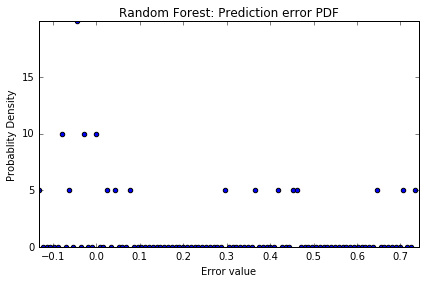

In [86]:
name = "Random Forest"
xs = test_scores_list
ys = predictions
results = sm.OLS(ys,sm.add_constant(xs)).fit() # gather all statistics (only used for our analysis)
# compute root mean squared error and R
mean_sq_error = np.mean((test_scores_list-predictions)**2)
r = np.corrcoef(test_scores_list,predictions)[0][1]
print name+" mean_sq_error = "+str(round(np.sqrt(mean_sq_error),3)) +  "& " + str(round(r**2,3)) , # A LaTeX table friendly printing format
# Plot the prediction error PDF
hist,bin_edges = np.histogram((test_scores_list-predictions),bins=100,density=True)
plt.title(name + ': Prediction error PDF')
plt.xlabel('Error value')
plt.ylabel('Probablity Density')    
plt.scatter(bin_edges[:-1],hist)
plt.xlim(min(bin_edges), max(bin_edges))
plt.ylim(min(hist), max(hist))
plt.tight_layout()
#plt.savefig(my_path+"/"+name+"_prediction_plot.png",dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
from scipy import interp

from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

cnt = 1
binding_skf = StratifiedKFold(n_splits=10)

tprs = []
sum_auc = 0
base_fpr = np.linspace(0, 1, 101)

y_real = []
y_proba = []

plt.figure(figsize=(5, 5))

for b_train_index, b_test_index in binding_skf.split(binding_features, binding_lables):
    binding_X_train, binding_X_test = binding_features.iloc[b_train_index,:], binding_features.iloc[b_test_index,:]
    binding_y_train, binding_y_test = binding_lables[b_train_index], binding_lables[b_test_index]
    
    
    neutral_big_skf = StratifiedKFold(n_splits=8)
    for n_ignore_index, n_eight_index in neutral_big_skf.split(neutral_features, neutral_lables):
        neutral_eight_features = neutral_features.iloc[n_eight_index,:]
        neutral_eight_labels = neutral_lables[n_eight_index]
        
        neutral_small_skf = StratifiedKFold(n_splits=10)
        for n_train_index, n_test_index in neutral_small_skf.split(neutral_eight_features, neutral_eight_labels):
            neutral_X_train, neutral_X_test = neutral_eight_features.iloc[n_train_index,:], neutral_eight_features.iloc[n_train_index,:]
            neutral_y_train, neutral_y_test = neutral_eight_labels[n_train_index], neutral_eight_labels[n_train_index]
            
            X_train = pd.concat([binding_X_train, neutral_X_train])
            X_test = pd.concat([binding_X_test, neutral_X_test])
            y_train = pd.concat([binding_y_train, neutral_y_train])
            y_test = pd.concat([binding_y_test, neutral_y_test])
    
            classifier = LogisticRegression() #- 10.66%
            #classifier = KNeighborsClassifier(n_neighbors=2)
            classifier.fit(X_train,y_train)
            y_pred = classifier.predict_proba(X_test)
            #y_pred = classifier.predict(X_test)
    
            #ROC curve calculations
            fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
            #fpr, tpr, _ = roc_curve(y_test, y_pred)
            sum_auc += auc(fpr, tpr)
            #plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            
            y_proba.append(y_pred[:,1])
            y_real.append(y_test)
            
            cnt += 1
            if (cnt % 100 == 0):
                print "Finished "+str(cnt)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
avg_auc = sum_auc/float(cnt)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished 700
Finished 800

In [29]:
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)

In [30]:
auc_pr = auc(recall, precision)
auc_pr

0.28140708991498403

In [6]:
KNeighborsClassifier(n_neighbors=3) - avg_auc = 0.66720473460640295
KNeighborsClassifier(n_neighbors=5) - avg_auc = 0.63996056671302903
KNeighborsClassifier(n_neighbors=10) - avg_auc = 0.61487235644402483
LogisticRegression() - avg_auc = 0.60508881221502731

0.63996056671302903

In [15]:
avg_auc

0.60508881221502731

In [17]:
#Split to train and test indices
k = 10
skf = StratifiedKFold(n_splits=10)
averageError = 0.0

for train_index, test_index in skf.split(binding_neutral_best_features, binding_neutral_labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = binding_neutral_best_features.iloc[train_index,:], binding_neutral_best_features.iloc[test_index,:]
    y_train, y_test = binding_neutral_labels[train_index], binding_neutral_labels[test_index]
    
    #classifier = svm.SVC()- 11.57%
    classifier = LogisticRegression() #- 10.66%
    #classifier = KNeighborsClassifier(n_neighbors=10) - 10.84%
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    error = zero_one_loss(y_test, y_pred)
    print error
    averageError += (1./k) * error
    
print "Average error: %4.2f%s" % (100 * averageError,'%')

0.11018793274
0.108803165183
0.107856718781
0.107856718781
0.107460914308
0.111023154562
0.107263012072
0.109835741144
0.107856718781
0.0878685929151
Average error: 10.66%


In [10]:
y_test.shape

(5053,)

In [ ]:
()

In [17]:
from scipy import interp

from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

X = binding_neutral_best_features
y = binding_neutral_labels

k=10
skf = StratifiedKFold(n_splits=k)

tprs = []
sum_auc = 0
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))

for train_index, test_index in skf.split(binding_neutral_best_features, binding_neutral_labels):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = binding_neutral_best_features.iloc[train_index,:], binding_neutral_best_features.iloc[test_index,:]
    y_train, y_test = binding_neutral_labels[train_index], binding_neutral_labels[test_index]
    
    classifier = LogisticRegression(class_weight = "balanced") #- 10.66%
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict_proba(X_test)
    
    
    fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
    sum_auc += auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    print "Finished skf"

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
avg_auc = sum_auc/float(k)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

Finished skf
Finished skf
Finished skf
Finished skf
Finished skf
Finished skf
Finished skf
Finished skf
Finished skf
Finished skf


In [23]:
predictions_dict ={}
predictions_dict["svm"] = y_pred

In [20]:
def plot_roc_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    plt.xlabel('False Positive Rate',fontsize=17)
    plt.ylabel('True Positive Rate',fontsize=17)
    ax.set_title("ROC Curve",fontsize=20)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        pred = predictions_dict[key]
        fpr, tpr, thresholds = roc_curve(label, pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr,  label= '{0}. Area: {1}'.format(key,round(roc_auc,2)),linestyle='--',linewidth=2,marker = markers[i%len(markers)],color = colors[i%len(colors)])
        i+=1
        #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.pdf")
    plt.show()

In [25]:
def plot_precision_recall_curve(predictions_dict,label):
    plt.clf()
    fig,ax = plt.subplots()        
    ax.set_xlabel("Recell",fontsize=17)
    ax.set_ylabel("Precision",fontsize=17)
    ax.set_title("Precision-Recall Curve",fontsize=20)
    fig.set_size_inches(10.0, 10.0, forward=True)
    i=0
    for key in predictions_dict.keys():
        precision, recall, thresholds = precision_recall_curve(label, predictions_dict[key])
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        f1_score = 2*mean_precision*mean_recall/(mean_precision+mean_recall)
        average_precision = average_precision_score(label, predictions_dict[key])
        plt.plot(recall, precision, label='{0}. Avg. precision: {1}, F1 score: {2}'.format(key,round(average_precision,2),round(f1_score,2)),linestyle='--',linewidth=2,marker = markers[i%len(markers)],color = colors[i%len(colors)])
        i+=1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.15])        
    plt.legend(loc="upper right")
    plt.savefig("precision_recall_curve.pdf")
    plt.show()

In [69]:
def get_train_test_inds(y ,train_proportion=0.9):
    '''Generates indices, making random stratified split into training set and testing sets
    with proportions train_proportion and (1-train_proportion) of initial sample.
    y is any iterable indicating classes of each observation in the sample.
    Initial proportions of classes inside training and 
    testing sets are preserved (stratified sampling).
    '''

    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds